In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
%cd ../scripts/
import sys
import os
sys.path.append("../")
sys.path.append("../Modules")
import analysis# Initialize a dictionary to store models
models = {}

# Path for Ben's model
ben_base_path = "L5BaselineResults/"

# Load data for 'ben' model
models['ben'] = {
    'v': np.array(h5py.File(ben_base_path + 'v_report.h5', 'r')['report']['biophysical']['data'][:50000,:]),
    'hva': np.array(h5py.File(ben_base_path + 'Ca_HVA.ica_report.h5', 'r')['report']['biophysical']['data']),
    'lva': np.array(h5py.File(ben_base_path + 'Ca_LVAst.ica_report.h5', 'r')['report']['biophysical']['data']),
    'ih': np.array(h5py.File(ben_base_path + 'Ih.ihcn_report.h5', 'r')['report']['biophysical']['data']),
    'nmda': np.array(h5py.File(ben_base_path + 'inmda_report.h5', 'r')['report']['biophysical']['data']),
    'na': np.array(h5py.File(ben_base_path + 'NaTa_t.gNaTa_t_report.h5', 'r')['report']['biophysical']['data']),
    'spktimes': h5py.File(ben_base_path + 'spikes.h5', 'r')['spikes']['biophysical']['timestamps'][:],
    'spkinds': np.sort((h5py.File(ben_base_path + 'spikes.h5', 'r')['spikes']['biophysical']['timestamps'][:] * 10).astype(int)),
    # 'na_df': pd.read_csv(ben_base_path + 'na.csv'),
    # 'ca_df': pd.read_csv(ben_base_path + 'ca.csv'),
    # 'nmda_df': pd.read_csv(ben_base_path + 'nmda.csv')
}

/home/drfrbc/Neural-Modeling/scripts


In [3]:
# Path for the refactored model
sim_directory = '2024-08-29-12-19-13-CheckdSpikes_AfterTuningSynapses_AfterUpdateExcRates/Complex_InhGmaxApic204_InhGmaxDend7.0_SomaGmax6.0_ExcGmax-1.0351_Np1000'
#'2024-07-09-11-52-35-FI2024-08-29-11-36-26-TuningSynapses_AfterUpdateExcRates_finalAdjustments/Complex_InhGmaxApic206.0_InhGmaxDend7.2_SomaGmax6.0_ExcGmax-1.0351_Np1000'
#'2024-08-23-15-05-35-TuningSynapses_finalSims/Complex_InhGmaxApic6.9_InhGmaxDend0.1_SomaGmax2.3_ExcGmax-1.0351_Np1000'
#'2024-08-23-09-50-35-TuningSynapses_finalSims/Complex_InhGmaxApic6.9_InhGmaxDend0.1_SomaGmax2.3_ExcGmax-1.0351_Np1000'

models['refactored'] = {
    'v': analysis.DataReader.read_data(sim_directory, "v").T,
    'hva': analysis.DataReader.read_data(sim_directory, "ica_Ca_HVA").T,
    'lva': analysis.DataReader.read_data(sim_directory, "ica_Ca_LVAst").T,
    'ih': analysis.DataReader.read_data(sim_directory, "ihcn_Ih").T,
    'nmda': analysis.DataReader.read_data(sim_directory, "i_NMDA").T,
    'na': analysis.DataReader.read_data(sim_directory, "gNaTa_t_NaTa_t").T,
    'spktimes': analysis.DataReader.read_data(sim_directory, "soma_spikes")[0][:],
    'spkinds': np.sort((analysis.DataReader.read_data(sim_directory, "soma_spikes")[0][:] * 10).astype(int)),
    # 'na_df': pd.read_csv(os.path.join(sim_directory, 'na.csv')),
    # 'ca_df': pd.read_csv(os.path.join(sim_directory, 'ca.csv')),
    # 'nmda_df': pd.read_csv(os.path.join(sim_directory, 'nmda.csv'))
}

--No graphics will be displayed.


In [4]:
# 2024-08-20-11-30-19-TuningSynapses_finalSims

In [5]:
# Load segment data for both models
segs_ben = pd.read_csv(ben_base_path + 'Segments.csv')
segs_degrees = pd.read_csv(ben_base_path + 'SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs_ben['segmentID'] = segs_ben.index
segs_ben = segs_ben.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()
segs_ben['Sec ID'] = segs_ben['Sec ID'].astype(int)
segs_ben['X'] = segs_ben['X'].astype(float)
segs_ben['Elec_distanceQ'] = 'None'
segs_ben.loc[segs_ben.Type=='dend','Elec_distanceQ'] = pd.qcut(segs_ben.loc[segs_ben.Type=='dend','Elec_distance'], 10, labels=False)
segs_ben.loc[segs_ben.Type=='apic','Elec_distanceQ'] = pd.qcut(segs_ben.loc[segs_ben.Type=='apic','Elec_distance'], 10, labels=False)

segs_refactored = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
segs_refactored['Sec ID'] = segs_refactored['idx_in_section_type']
segs_refactored['Type'] = segs_refactored['section']
segs_refactored['Coord X'] = segs_refactored['pc_0']
segs_refactored['Coord Y'] = segs_refactored['pc_1']
segs_refactored['Coord Z'] = segs_refactored['pc_2']
elec_dist = pd.read_csv(os.path.join(sim_directory, f"elec_distance_{'soma'}.csv"))
segs_refactored['Elec_distance'] = elec_dist['25_active']
elec_dist = pd.read_csv(os.path.join(sim_directory, f"elec_distance_{'nexus'}.csv"))
segs_refactored['Elec_distance_nexus'] = elec_dist['25_active']
Xs = []
for seg in segs_refactored['seg']:
    Xs.append(seg.split('(')[-1].split(')')[0])
segs_refactored['X'] = Xs

# continue
segs_refactored['segmentID'] = segs_refactored.index

segs_refactored['Sec ID'] = segs_refactored['Sec ID'].astype(int)
segs_refactored['X'] = segs_refactored['X'].astype(float)
segs_refactored['Elec_distanceQ'] = 'None'

segs_refactored.loc[segs_refactored.Type=='dend','Elec_distanceQ'] = pd.qcut(segs_refactored.loc[segs_refactored.Type=='dend','Elec_distance'], 10, labels=False)
segs_refactored.loc[segs_refactored.Type=='apic','Elec_distanceQ'] = pd.qcut(segs_refactored.loc[segs_refactored.Type=='apic','Elec_distance'], 10, labels=False)

Shift applied to refactored segments: X=-45.932710375104605, Y=-18.356623331705777, Z=50.25


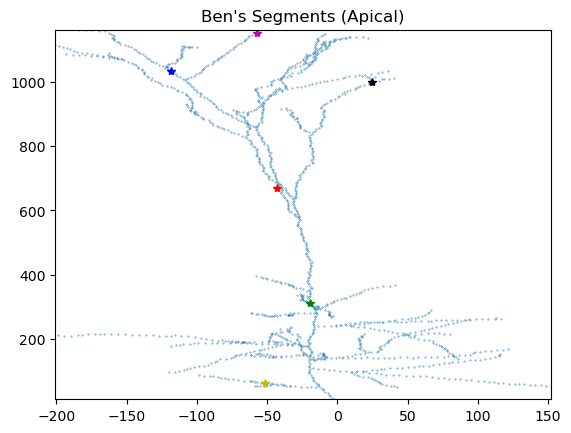

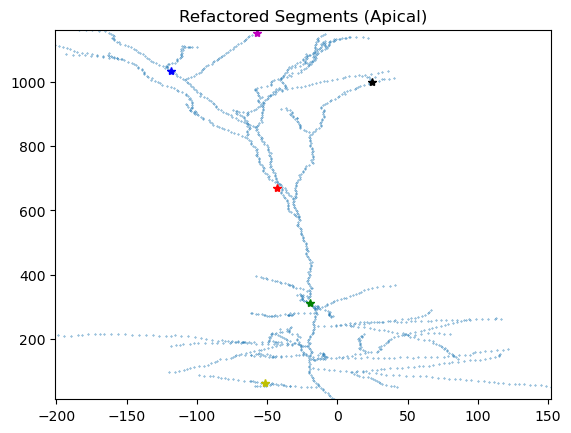

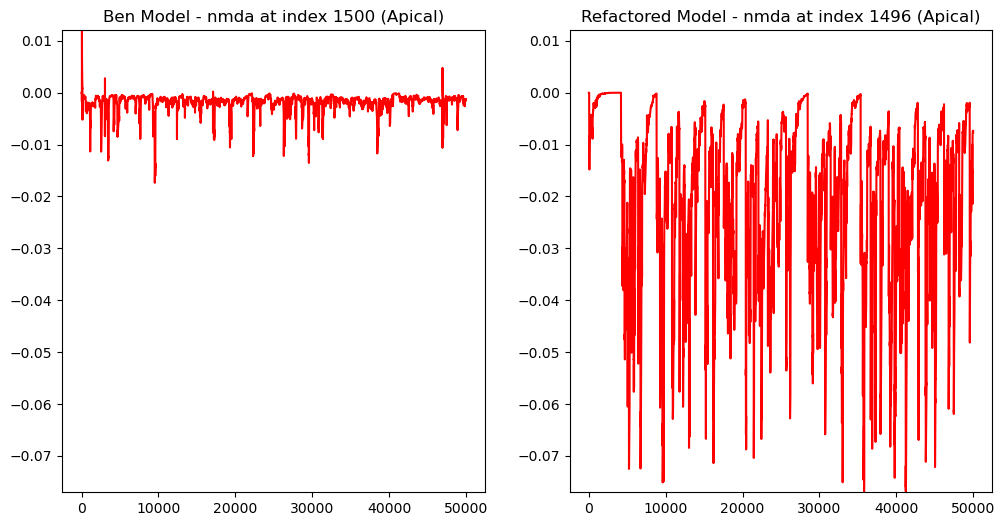

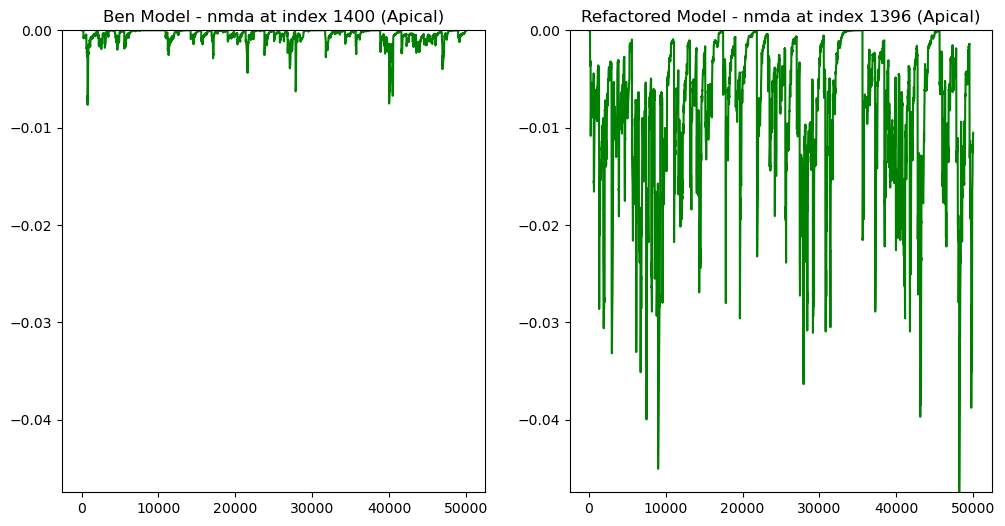

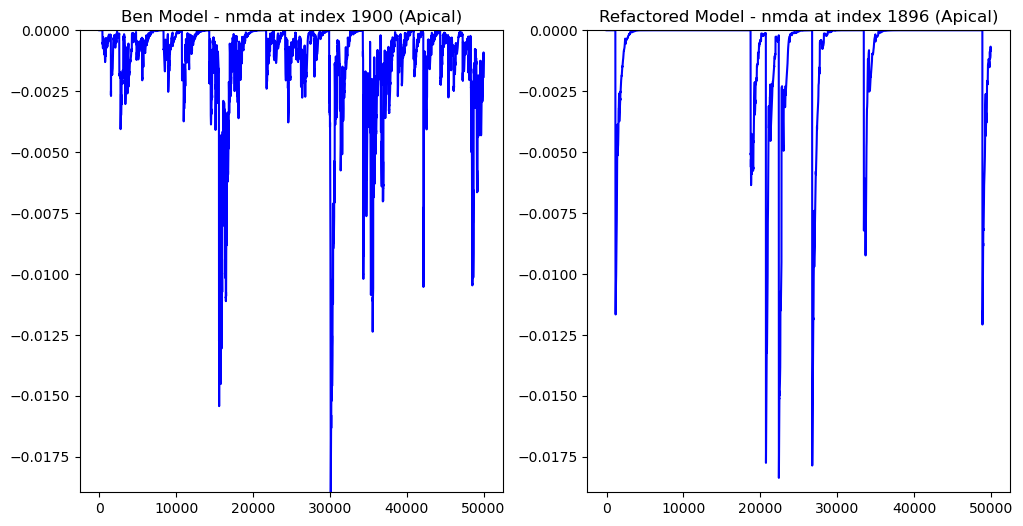

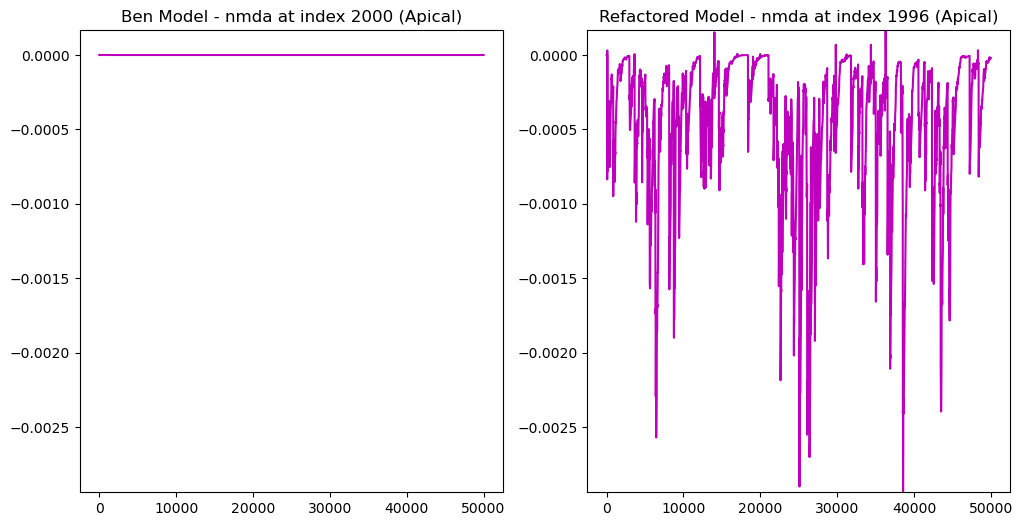

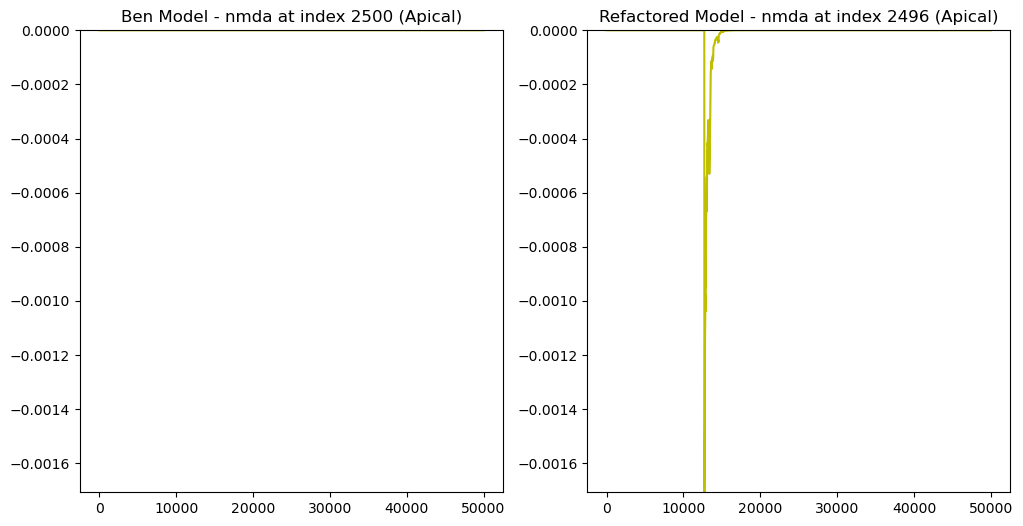

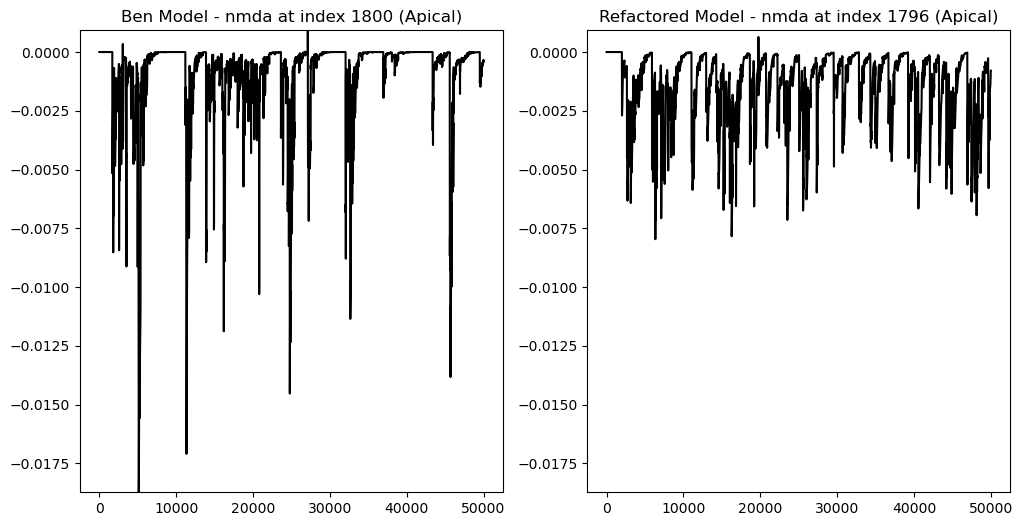

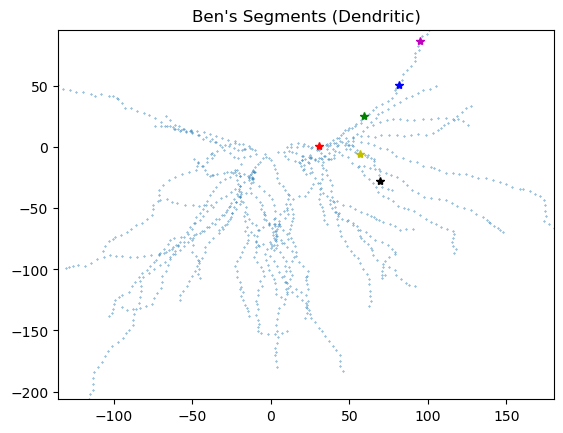

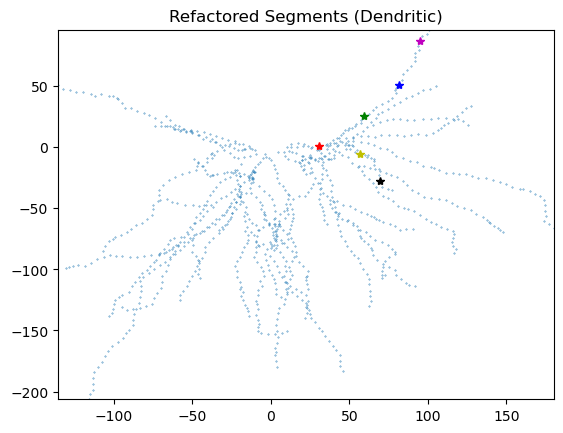

/tmp/ipykernel_196250/898058773.py:92: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([combined_min, combined_max])
/tmp/ipykernel_196250/898058773.py:98: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([combined_min, combined_max])


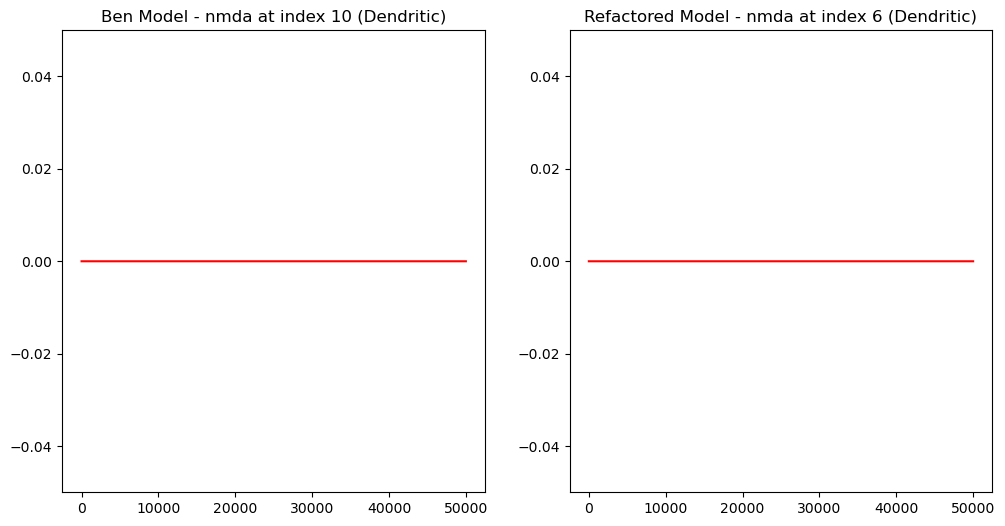

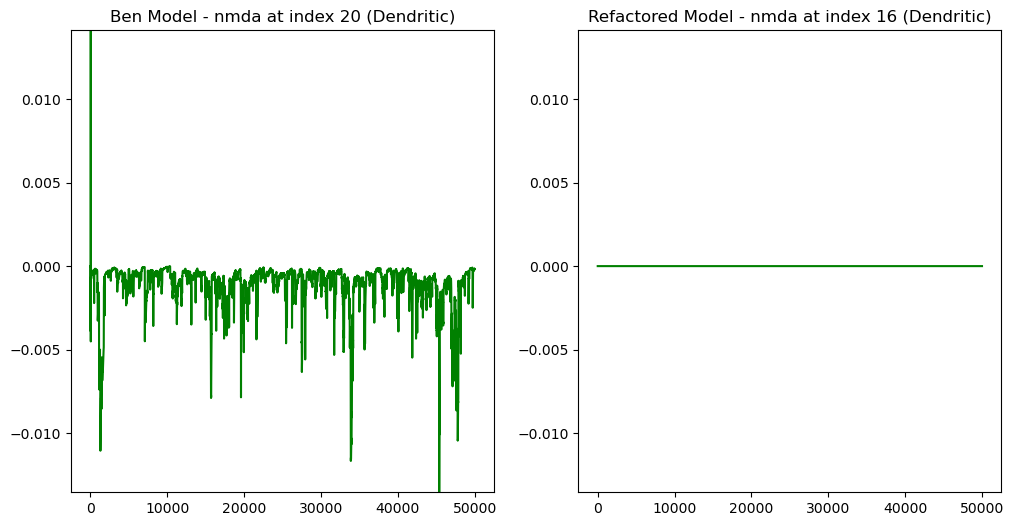

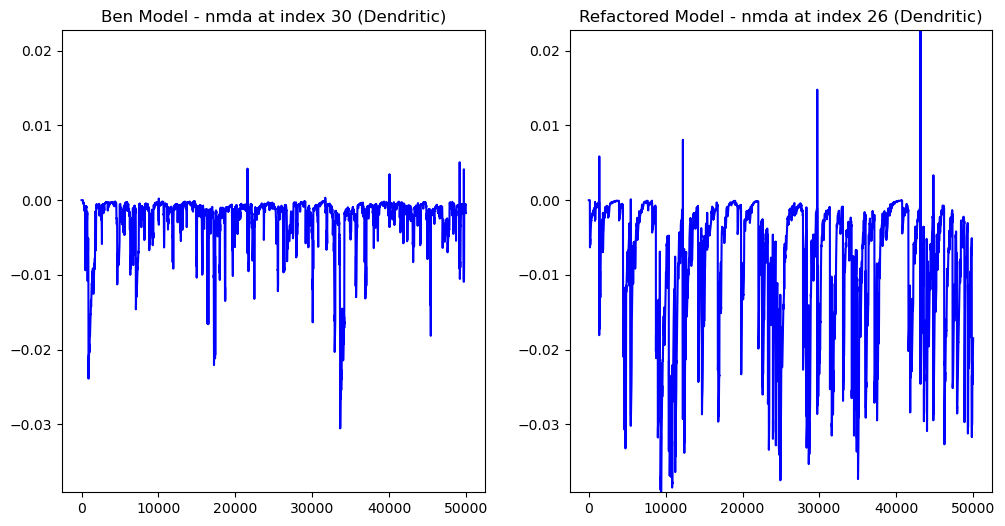

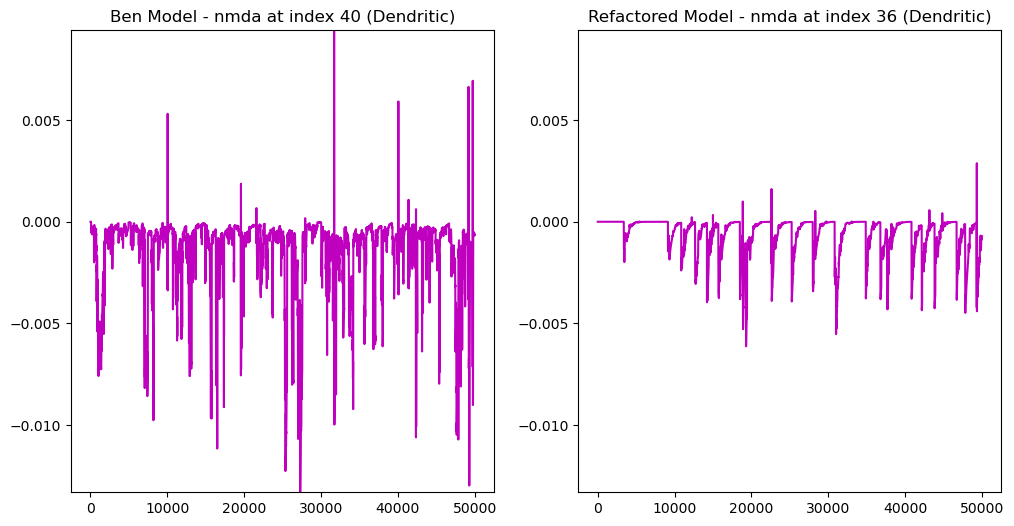

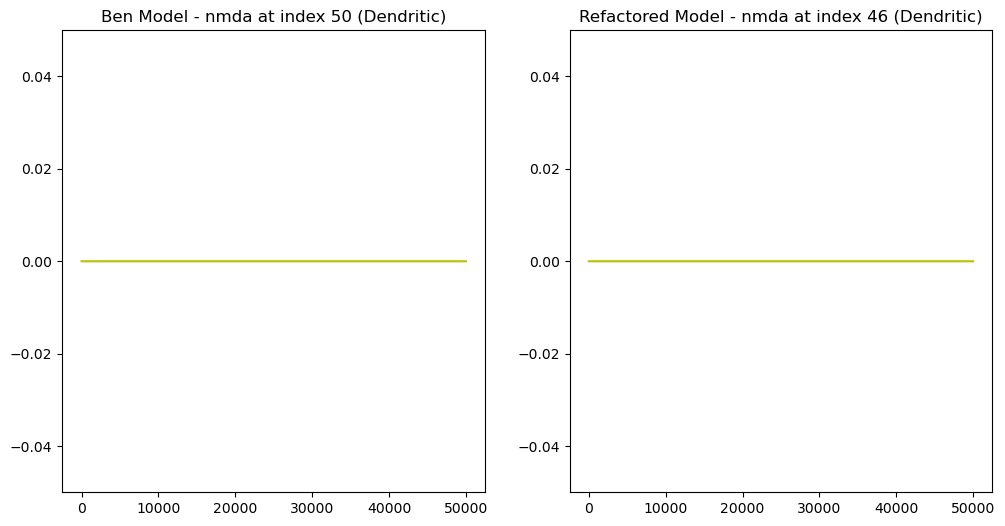

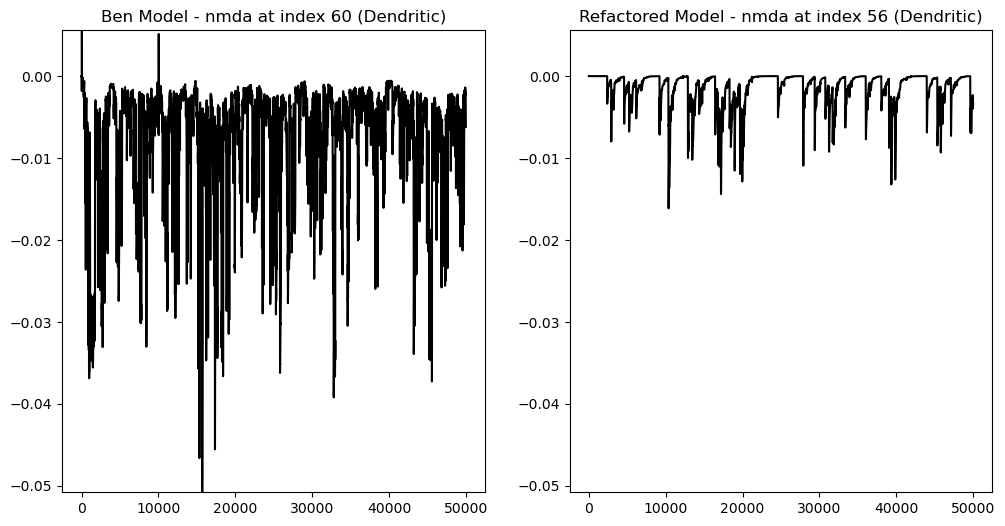

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

def calculate_shift_and_apply(ben_segs, refactored_segs):
    # Calculate the min and max for each coordinate of Ben's segments
    ben_min_x = ben_segs['Coord X'].min()
    ben_max_x = ben_segs['Coord X'].max()
    ben_min_y = ben_segs['Coord Y'].min()
    ben_max_y = ben_segs['Coord Y'].max()
    ben_min_z = ben_segs['Coord Z'].min()
    ben_max_z = ben_segs['Coord Z'].max()

    # Calculate the min and max for each coordinate of the refactored segments
    refactored_min_x = refactored_segs['Coord X'].min()
    refactored_max_x = refactored_segs['Coord X'].max()
    refactored_min_y = refactored_segs['Coord Y'].min()
    refactored_max_y = refactored_segs['Coord Y'].max()
    refactored_min_z = refactored_segs['Coord Z'].min()
    refactored_max_z = refactored_segs['Coord Z'].max()

    # Calculate the average shift needed for each axis
    shift_x = ((ben_min_x - refactored_min_x) + (ben_max_x - refactored_max_x)) / 2
    shift_y = ((ben_min_y - refactored_min_y) + (ben_max_y - refactored_max_y)) / 2
    shift_z = ((ben_min_z - refactored_min_z) + (ben_max_z - refactored_max_z)) / 2

    # Apply the shifts to the refactored segments using .loc to avoid SettingWithCopyWarning
    refactored_segs.loc[:, 'Coord X'] += shift_x
    refactored_segs.loc[:, 'Coord Y'] += shift_y
    refactored_segs.loc[:, 'Coord Z'] += shift_z

    print(f"Shift applied to refactored segments: X={shift_x}, Y={shift_y}, Z={shift_z}")
    return refactored_segs

def map_segments(ben_segs, refactored_segs):
    segment_mapping = {}

    # Loop through each segment in Ben's data
    for i, row in ben_segs.iterrows():
        ben_coords = np.array([row['Coord X'], row['Coord Y'], row['Coord Z']])
        # Calculate the distance from the current Ben's segment to all segments in the refactored data
        refactored_coords = refactored_segs[['Coord X', 'Coord Y', 'Coord Z']].values
        dists = distance.cdist([ben_coords], refactored_coords, 'euclidean').flatten()
        
        # Find the index of the closest segment in the refactored data
        closest_index = np.argmin(dists)
        
        # Store the mapping (Ben's segment ID -> Refactored segment ID)
        segment_mapping[row['segmentID']] = refactored_segs.iloc[closest_index]['segmentID']

    return segment_mapping

def plot_segments(ben_segs, refactored_segs, segment_mapping, indices, colors, title_suffix=""):
    # Calculate the axis limits
    all_coords_x = ben_segs['Coord X'].tolist() + refactored_segs['Coord X'].tolist()
    all_coords_y = ben_segs['Coord Y'].tolist() + refactored_segs['Coord Y'].tolist()
    x_min, x_max = min(all_coords_x), max(all_coords_x)
    y_min, y_max = min(all_coords_y), max(all_coords_y)

    for i, segs in enumerate([ben_segs, refactored_segs]):
        plt.figure()
        plt.scatter(segs['Coord X'], segs['Coord Y'], s=0.1)
        for j, ind in enumerate(indices):
            if i == 1:
                ind = segment_mapping[ind]
            plt.plot(segs.loc[segs.segmentID.isin([ind]), 'Coord X'], 
                     segs.loc[segs.segmentID.isin([ind]), 'Coord Y'], colors[j])
        
        plt.title(f"Ben's Segments {title_suffix}" if i == 0 else f"Refactored Segments {title_suffix}")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.show()

def plot_something(models, segment_mapping, indices, colors, title_suffix="", time_points=np.arange(0, 50000), var_name='v'):
    colors = [color.split('*')[0] for color in colors]
    
    for i, idx in enumerate(indices):
        plt.figure(figsize=(12, 6))
        
        # Extract the data for both plots
        ben_data = models['ben'][var_name][time_points, idx]
        refactored_data = models['refactored'][var_name][time_points, segment_mapping[idx]]
        
        # Determine the combined y-limits
        combined_min = min(ben_data.min(), refactored_data.min())
        combined_max = max(ben_data.max(), refactored_data.max())
        
        # Plot Ben model data
        plt.subplot(1, 2, 1)
        plt.plot(ben_data, colors[i])
        plt.ylim([combined_min, combined_max])
        plt.title(f'Ben Model - {var_name} at index {idx} {title_suffix}')
        
        # Plot Refactored model data
        plt.subplot(1, 2, 2)
        plt.plot(refactored_data, colors[i])
        plt.ylim([combined_min, combined_max])
        plt.title(f'Refactored Model - {var_name} at index {segment_mapping[idx]} {title_suffix}')
        
        plt.show()

        
# Example usage:
# Assuming segs_ben and segs_refactored are your dataframes
segs_refactored = calculate_shift_and_apply(segs_ben, segs_refactored)

# Filter for specific segment types
apic_segs_ben = segs_ben[segs_ben['Type']=='apic']
apic_segs_refactored = segs_refactored[segs_refactored['Type']=='apic']

# Calculate shifts and apply them
# apic_segs_refactored_shifted = calculate_shift_and_apply(apic_segs_ben, apic_segs_refactored)

# Map segments
apic_segment_mapping = map_segments(apic_segs_ben, apic_segs_refactored)

# Plot segments
apic_indices = [1500, 1400, 1900, 2000, 2500, 1800]
colors = ['r*', 'g*', 'b*', 'm*', 'y*', 'k*']
plot_segments(apic_segs_ben, apic_segs_refactored, apic_segment_mapping, apic_indices, colors, title_suffix="(Apical)")

# Plot voltage
plot_something(models, apic_segment_mapping, apic_indices, colors, title_suffix="(Apical)", var_name ='nmda')

# Now for dendritic segments
dend_segs_ben = segs_ben[segs_ben['Type']=='dend']
dend_segs_refactored = segs_refactored[segs_refactored['Type']=='dend']

# Calculate shifts and apply them
# dend_segs_refactored_shifted = calculate_shift_and_apply(dend_segs_ben, dend_segs_refactored)

# Map segments
dend_segment_mapping = map_segments(dend_segs_ben, dend_segs_refactored)

# Plot segments
dend_indices = [10, 20, 30, 40, 50, 60]
plot_segments(dend_segs_ben, dend_segs_refactored, dend_segment_mapping, dend_indices, colors, title_suffix="(Dendritic)")

# Plot voltage
plot_something(models, dend_segment_mapping, dend_indices, colors, title_suffix="(Dendritic)", var_name = 'nmda')


Since sometimes refactored is lower and sometimes original is lower, let's try to characterize across all segments at once.

In [7]:
var_name = 'nmda'
time_points =np.arange(0, 50000)
ben_nmda = np.mean([models['ben'][var_name][time_points, idx] for idx in apic_indices])
refactored_nmda = np.mean([models['refactored'][var_name][time_points, apic_segment_mapping[idx]] for idx in apic_indices])

In [8]:
ben_nmda

-0.0007533969145912552

In [9]:
refactored_nmda

-0.005142470367969144

Now check mdian and basal

In [10]:
ben_nmda = np.median([models['ben'][var_name][time_points, idx] for idx in apic_indices])
refactored_nmda = np.median([models['refactored'][var_name][time_points, apic_segment_mapping[idx]] for idx in apic_indices])

In [11]:
ben_nmda = np.mean([models['ben'][var_name][time_points, idx] for idx in apic_indices])
refactored_nmda = np.mean([models['refactored'][var_name][time_points, dend_segment_mapping[idx]] for idx in dend_indices])

In [12]:
refactored_nmda

-0.0017238943777725872

In [13]:
ben_nmda

-0.0007533969145912552

Check synapse spike files

In [14]:
exc_spikes = h5py.File(ben_base_path + 'exc_stim_spikes2.h5', 'r')
inh_spikes = h5py.File(ben_base_path + 'dist_inh_stim_spikes2.h5', 'r')
soma_spikes = h5py.File(ben_base_path + 'prox_inh_stim_spikes2.h5', 'r')

In [15]:
exc_spikes = np.array(exc_spikes['spikes']['exc_stim']['node_ids'])
inh_spikes = np.array(inh_spikes['spikes']['dist_inh_stim']['node_ids'])
soma_spikes = np.array(soma_spikes['spikes']['prox_inh_stim']['node_ids'])

# timestamps = np.array(exc_spikes['spikes']['exc_stim']['timestamps'])

In [16]:
# # Filter the data
# mask = timestamps < 100
# filtered_timestamps = timestamps[mask]
# filtered_node_ids = node_ids[mask]

# # Plot the data
# plt.scatter(filtered_timestamps, filtered_node_ids, linewidths=1e-15)
# plt.show()

Firing rate of each preseynaptic cell

In [17]:
exc_spikes

array([   0,    0,    0, ..., 5221, 5221, 5221])

In [18]:
def get_node_spike_trains(node_ids):
    # count the number of times the node_id appears.
    # Count the occurrences of each unique node_id
    unique_nodes, counts = np.unique(node_ids, return_counts=True)

    # Combine the unique node_ids with their corresponding counts (firing rates)
    # firing_rates = dict(zip(unique_nodes, counts))
    
    return counts

exc_spikes = get_node_spike_trains(exc_spikes)
inh_spikes = get_node_spike_trains(inh_spikes)
soma_spikes = get_node_spike_trains(soma_spikes)


# # Display the firing rates
# for node, rate in firing_rates.items():
#     print(f"Node {node} has {rate} spikes.")

In [19]:
refactored_exc_spikes = h5py.File(os.path.join(sim_directory, 'exc_spike_trains.h5'), 'r')
refactored_inh_spikes = h5py.File(os.path.join(sim_directory, 'inh_spike_trains.h5'), 'r')
refactored_soma_spikes = h5py.File(os.path.join(sim_directory, 'soma_spike_trains.h5'), 'r')

refactored_exc_spikes = [np.array(refactored_exc_spikes[key]) for key in refactored_exc_spikes.keys()]
refactored_inh_spikes = [np.array(refactored_inh_spikes[key]) for key in refactored_inh_spikes.keys()]
refactored_soma_spikes = [np.array(refactored_soma_spikes[key]) for key in refactored_soma_spikes.keys()]
# identify unique spike trains.

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '2024-08-29-12-19-13-CheckdSpikes_AfterTuningSynapses_AfterUpdateExcRates/Complex_InhGmaxApic204_InhGmaxDend7.0_SomaGmax6.0_ExcGmax-1.0351_Np1000/exc_spike_trains.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
spikes_dict = {
    'soma': (soma_spikes, refactored_soma_spikes),
    'exc': (exc_spikes, refactored_exc_spikes),
    'inh': (inh_spikes, refactored_inh_spikes)
}

In [ ]:
def get_node_trains_from_all_spikes_trains(spikes):
    # Convert numpy arrays to tuples and use a set to find unique arrays
    unique_arrays = []
    seen = set()

    for arr in spikes:
        arr_tuple = tuple(arr)
        if arr_tuple not in seen:
            seen.add(arr_tuple)
            unique_arrays.append(arr)
            
            
    unique_arrays = np.array([len(spikes) for spikes in unique_arrays])
    return unique_arrays

def get_spike_trains(spikes_trains):
    # alternative that does not separate by nodes.
    return np.array([len(spikes) for spikes in spikes_trains])

# unique_arrays now contains the unique numpy arrays
# print(len(refactored_exc_spikes))
# print(len(get_node_trains_from_all_spikes_trains(refactored_exc_spikes)))

for key in spikes_dict.keys():
    spikes_dict[key] = (spikes_dict[key][0], get_node_trains_from_all_spikes_trains(spikes_dict[key][1]))
    # spikes_dict[key] = (spikes_dict[key][0], get_spike_trains(spikes_dict[key][1]))

In [ ]:
# for unique_array in unique_arrays:
#     print(len(unique_array)*3)

In [ ]:
# refactored_counts = np.array([len(spikes) for spikes in refactored_exc_spikes])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for key in spikes_dict.keys():
    # Normalize the firing rates to Hz
    rates = spikes_dict[key][0] * 1000 / 150000
    refactored_rates = spikes_dict[key][1] * 1000 / 50000

    # Interpolate refactored_rates to match the size of rates
    if len(rates) > len(refactored_rates):
        refactored_rates = np.interp(np.linspace(0, len(refactored_rates) - 1, len(rates)), 
                                     np.arange(len(refactored_rates)), refactored_rates)
    else:
        rates = np.interp(np.linspace(0, len(rates) - 1, len(refactored_rates)), 
                          np.arange(len(rates)), rates)

    # Define the bin edges for consistency
    bins = 30

    plt.figure(figsize=(16, 6))

    # Set the overall figure title using the key
    plt.suptitle(f'Firing Rate Analysis for {key}', fontsize=16)

    # Plot histogram for original firing rates as a percentage of nodes
    plt.subplot(1, 4, 1)
    plt.hist(rates, bins=bins, color='blue', alpha=0.7, edgecolor='black', weights=np.ones(len(rates)) / len(rates) * 100)
    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('Percentage of Nodes')
    plt.title('Original Firing Rates')
    print(f"mean: {np.mean(rates)}, std: {np.std(rates)}")

    # Plot histogram for refactored firing rates as a percentage of nodes
    plt.subplot(1, 4, 2)
    plt.hist(refactored_rates, bins=bins, color='orange', alpha=0.7, edgecolor='black', weights=np.ones(len(refactored_rates)) / len(refactored_rates) * 100)
    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('Percentage of Nodes')
    plt.title('Refactored Firing Rates')

    # Plot histogram for difference in firing rates as a percentage of nodes
    plt.subplot(1, 4, 3)
    plt.hist(new_rates, bins=bins, color='green', alpha=0.7, edgecolor='black', weights=np.ones(len(new_rates)) / len(new_rates) * 100)
    plt.xlabel('Difference in Firing Rates (Hz)')
    plt.ylabel('Percentage of Nodes')
    plt.title('Difference in Firing Rates (Original - Refactored)')

    # Plot overlayed histograms of original and refactored firing rates as a percentage of nodes
    plt.subplot(1, 4, 4)
    plt.hist(rates, bins=bins, color='blue', alpha=0.7, edgecolor='black', weights=np.ones(len(rates)) / len(rates) * 100, label='Original')
    plt.hist(refactored_rates, bins=bins, color='orange', alpha=0.7, edgecolor='black', weights=np.ones(len(refactored_rates)) / len(refactored_rates) * 100, label='Refactored')
    plt.hist(new_rates, bins=bins, color='green', alpha=0.7, edgecolor='black', weights=np.ones(len(new_rates)) / len(new_rates) * 100, label='Distribution')
    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('Percentage of Nodes')
    plt.title('Overlayed Histograms of Firing Rates')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()


In [ ]:
from functools import partial
import scipy.stats as st
mean_fr_dist = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92, scale=0.44, size=1)
rates = mean_fr_dist(size=100000)
rates = np.clip(rates, 0,1e15)
plt.hist(rates, bins=bins, alpha=0.7, edgecolor='black', weights=np.ones(len(rates)) / len(rates) * 100)

In [ ]:
mean_fr, std_fr = 4.43, 2.9
mean_fr, std_fr = 6.7967, 4.3#3.450281247932259
a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
mean_fr_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)
rates = mean_fr_dist(size=100000)
rates = np.clip(rates, 0,1e15)
plt.hist(rates, bins=bins, alpha=0.7, edgecolor='black', weights=np.ones(len(rates)) / len(rates) * 100)

In [ ]:
new_rates=rates